<a href="https://colab.research.google.com/github/puraminy/mini_proj3/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Alphabets Dataset

Cloning into 'mini_proj3'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 164 (delta 14), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (164/164), 6.07 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (79/79), done.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((500, 784), (500,), 7, 0)

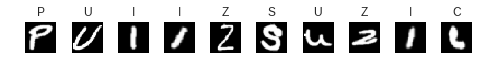

In [1]:
#!git clone "https://github.com/puraminy/mini_proj3"
!rm -r 'mini_proj3'
!git clone "https://github.com/puraminy/mini_proj3"
from mini_proj3.mysom import MiniSom

import numpy as np
alphabet = np.load('mini_proj3/Alphabets.npy')
label = np.load('mini_proj3/Alphabet_labels.npy')
label2 = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z']


import matplotlib.pyplot as plt
idx = np.random.randint(499, size=10)

fig, axes = plt.subplots(1, 10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.5)

# for i in range(len(alphabet)):
#   alphabet[i] = alphabet[i] * (255.0 / alphabet[i].max())

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
alphabet = sc.fit_transform(alphabet)
  
pltalpha = alphabet[idx,:]
pltlbl = label[idx]

for i in range(10):
  axes[i].imshow(-1*np.reshape(pltalpha[i,:],[28,28]))
  axes[i].axis('off')
  xlabel = label2[pltlbl[i]]; axes[i].set_title(xlabel)



alphabet.shape, label.shape, max(label), min(label)


#SOM

##Constant Parameters

In [2]:
features = 28*28
learningrate = 1
# ini_weights (1) PCA
#som0 = MiniSom(x=25, y=25, input_len=features)  # initialization of 25x25 SOM
#som0.pca_weights_init(alphabet)
#ini_weights = som0._weights.copy()

# ini_weights (2) Distribute from min to max value of input data [0:1]    
#ini_weights = np.expand_dims(np.linspace(0, 1, x*y),axis=1)*np.ones([1,features])
#ini_weights = np.reshape(ini_weights, [x, y, features])

# ini_weights (3) Input mean values    
#ini_weights = np.expand_dims(np.mean(alphabet,axis=0),axis=1)*np.ones([1,x*y])
#ini_weights = np.reshape(weights, [x, y, features])

# ini_weights (4) Random
#ini_weights = np.random.random([x,y,features])
som0 = MiniSom(x=25, y=25, input_len=features)  # initialization of 25x25 SOM
som0.random_weights_init(alphabet)
ini_weights = som0._weights.copy()

# ini_weights (5) Zeros
#ini_weights = np.zeros([x,y,features])

# ini_weights (6) Ones
#ini_weights = np.ones([x,y,features])
print(ini_weights)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [3]:
max_iter = 1000
learning_rate = 1
eta = learning_rate
for t in range(max_iter):
  eta = eta*0.9 # / (1+t/(max_iter/2))
  print(eta)

0.9
0.81
0.7290000000000001
0.6561000000000001
0.5904900000000002
0.5314410000000002
0.47829690000000014
0.43046721000000016
0.38742048900000015
0.34867844010000015
0.31381059609000017
0.28242953648100017
0.25418658283290013
0.22876792454961012
0.2058911320946491
0.1853020188851842
0.16677181699666577
0.1500946352969992
0.13508517176729928
0.12157665459056936
0.10941898913151243
0.0984770902183612
0.08862938119652508
0.07976644307687257
0.07178979876918531
0.06461081889226679
0.05814973700304011
0.0523347633027361
0.04710128697246249
0.042391158275216244
0.03815204244769462
0.03433683820292516
0.030903154382632643
0.02781283894436938
0.025031555049932444
0.0225283995449392
0.020275559590445278
0.01824800363140075
0.016423203268260675
0.014780882941434608
0.013302794647291147
0.011972515182562033
0.01077526366430583
0.009697737297875247
0.008727963568087723
0.00785516721127895
0.007069650490151055
0.00636268544113595
0.005726416897022355
0.00515377520732012
0.004638397686588107
0.004174

#Part A

 [    0 / 2000 ]   0% ? it/siteration= 0 delta = 2.7755575615628914e-17


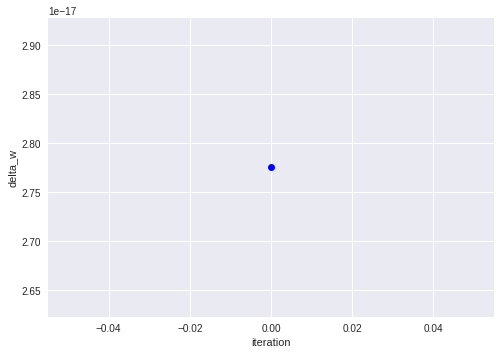

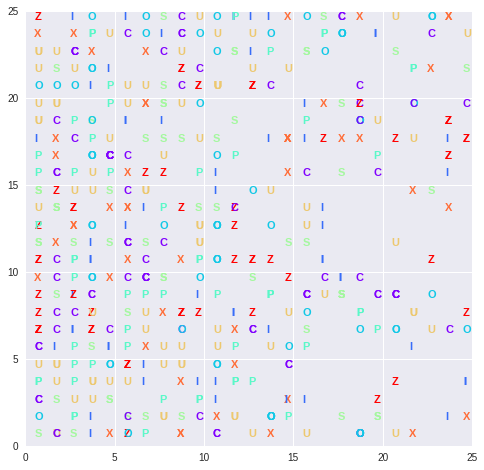

Number of Winning Nodes: 358


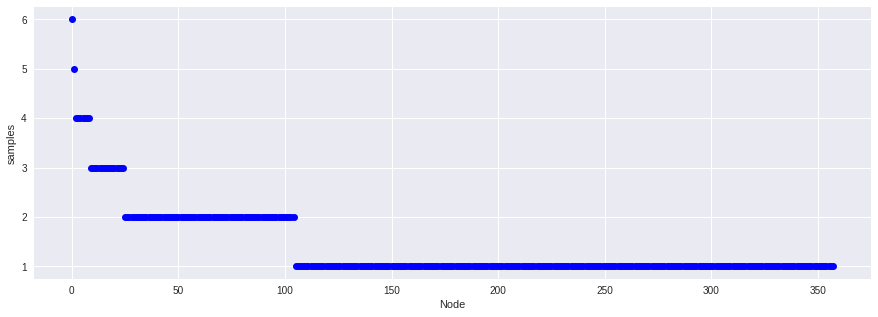

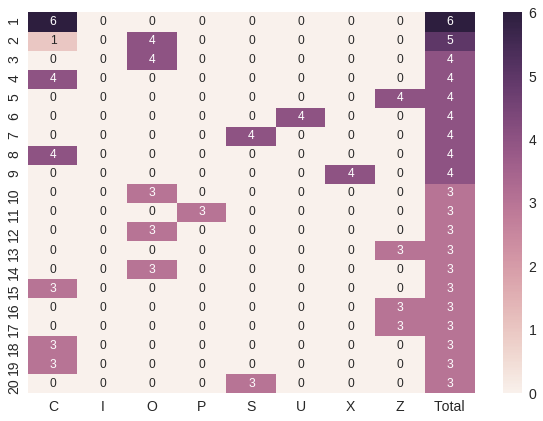

In [4]:
x = 25; y = 25
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 0

#neighborhood='mexican_hat'
#neighborhood='bubble'
#neighborhood='gaussian'
neighborhood='triangle'

somA = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood)
somA._weights = ini_weights
#somA.random_weights_init(alphabet)  # initialize weights with random values 
somA.train_delta(alphabet, delta=0.0001, max_iteration=2000, verbose=True, decay_lr=0.9, decay_sigma=0.9)

weightsA = somA._weights



# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somA.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weightsA.shape[0], 0,  weightsA.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somA.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
for i in range(len(mappings)):
  plt.plot(i, len(np.flipud(sorted_values)[i]),'bo')
  plt.xlabel('Node')
  plt.ylabel('samples')
  
  
if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()


#Part B

/content/mini_proj3/mysom.py:119: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


 [    0 / 2000 ]   0% ? it/siteration= 0 delta = 0.11999092654870676
 [    1 / 2000 ]   0% 0.03302 it/siteration= 1 delta = 0.0989433313844818
 [    2 / 2000 ]   0% 0.02512 it/siteration= 2 delta = 0.11997939367893971
 [    3 / 2000 ]   0% 0.02232 it/siteration= 3 delta = 0.12479960209013868
 [    4 / 2000 ]   0% 0.02089 it/siteration= 4 delta = 0.13414069198914744
 [    5 / 2000 ]   0% 0.02005 it/siteration= 5 delta = 0.11269832667015713
 [    6 / 2000 ]   0% 0.01941 it/siteration= 6 delta = 0.141555956329351
 [    7 / 2000 ]   0% 0.01900 it/siteration= 7 delta = 0.13075691788783528
 [    8 / 2000 ]   0% 0.01867 it/siteration= 8 delta = 0.11164475359290549
 [    9 / 2000 ]   0% 0.01846 it/siteration= 9 delta = 0.11118704713417894
 [   10 / 2000 ]   0% 0.01826 it/siteration= 10 delta = 0.10363886946663495
 [   11 / 2000 ]   1% 0.01900 it/siteration= 11 delta = 0.12908984387570352
 [   12 / 2000 ]   1% 0.01879 it/siteration= 12 delta = 0.13181023798704286
 [   13 / 2000 ]   1% 0.01859 i

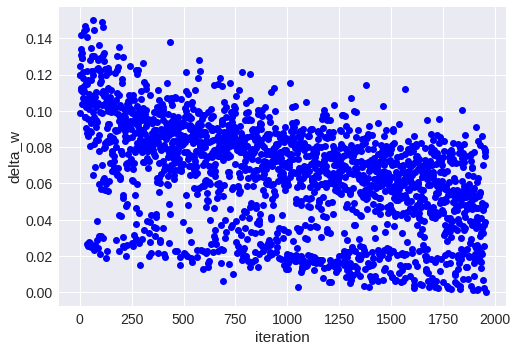

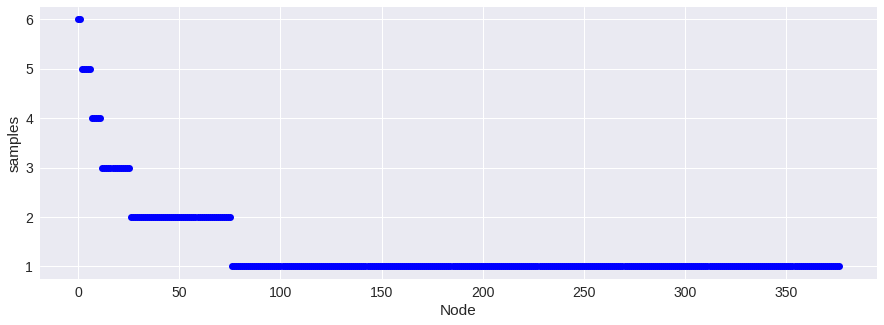

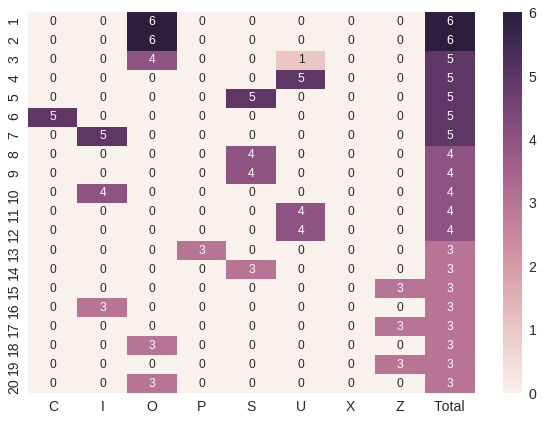

In [5]:
x = 625; y = 1
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 1

#neighborhood='mexican_hat'
#neighborhood='bubble'
neighborhood='gaussian'
#neighborhood='triangle'

somB = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood) 
somB._weights = ini_weights
#somB.random_weights_init(alphabet)  # initialize weights with random values 
somB.train_delta(alphabet, delta=0.0001, max_iteration=2000, verbose=True)

weightsB = somB._weights



# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somB.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weightsB.shape[0], 0,  weightsB.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somB.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
for i in range(len(mappings)):
  plt.plot(i, len(np.flipud(sorted_values)[i]),'bo')
  plt.xlabel('Node')
  plt.ylabel('samples')
  
if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()


#Part C

In [0]:
x = 25; y = 25
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 1

#neighborhood='mexican_hat'
#neighborhood='bubble'
neighborhood='gaussian'
#neighborhood='triangle'

somC = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood) 
somC._weights = ini_weights
#somC.random_weights_init(alphabet)  # initialize weights with random values 
somC.train_delta(alphabet, delta=0.0001, max_iteration=2000, verbose=True)

weightsC = somC._weights



# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somC.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weightsC.shape[0], 0,  weightsC.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somC.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
for i in range(len(mappings)):
  plt.plot(i, len(np.flipud(sorted_values)[i]),'bo')
  plt.xlabel('Node')
  plt.ylabel('samples')

if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()


 [    0 / 2000 ]   0% ? it/siteration= 0 delta = 0.1254191584856877
 [    1 / 2000 ]   0% 0.03247 it/siteration= 1 delta = 0.11227573761985915
 [    2 / 2000 ]   0% 0.02440 it/siteration= 2 delta = 0.10392387898434681
 [    3 / 2000 ]   0% 0.02170 it/siteration= 3 delta = 0.11545905585729774
 [    4 / 2000 ]   0% 0.02040 it/siteration= 4 delta = 0.11341637036377897
 [    5 / 2000 ]   0% 0.01965 it/siteration= 5 delta = 0.07253132022485108
 [    6 / 2000 ]   0% 0.01907 it/siteration= 6 delta = 0.11115301467296103
 [    7 / 2000 ]   0% 0.01873 it/siteration= 7 delta = 0.10809560271925166
 [    8 / 2000 ]   0% 0.01850 it/siteration= 8 delta = 0.11186666231980708
 [    9 / 2000 ]   0% 0.01823 it/siteration= 9 delta = 0.10317129355677818
 [   10 / 2000 ]   0% 0.01801 it/siteration= 10 delta = 0.1276385051669388
 [   11 / 2000 ]   1% 0.01795 it/siteration= 11 delta = 0.09441418997250782
 [   12 / 2000 ]   1% 0.01837 it/siteration= 12 delta = 0.10299156017498087
 [   13 / 2000 ]   1% 0.01828 